In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

In [2]:
path='data/ml-latest-small/'

In [3]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
ratings.shape

(100004, 4)

In [5]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# Regular Way with Adam 

In [7]:
val_idxs = get_cv_idxs(len(ratings))
wd=2e-4
n_factors = 50

In [27]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [21]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 72%|███████▏  | 899/1251 [00:02<00:00, 418.79it/s, loss=4.58]


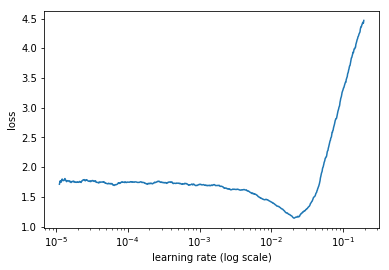

In [22]:
learn.sched.plot()

In [23]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.771751   0.803957  
    1      0.785828   0.779445                                  
    2      0.611204   0.764466                                  



[array([0.76447])]

In [24]:
math.sqrt(0.764)

0.8740709353364863

In [49]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.SGD)

In [50]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      1.021885   1.128917  



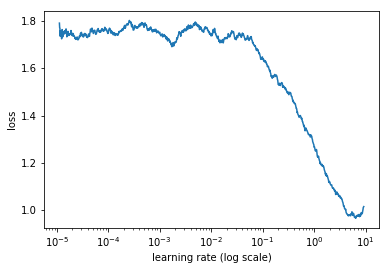

In [51]:
learn.sched.plot()

In [52]:
learn.fit(0.4, 2, wds=wd, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      1.009521   0.977178  
    1      0.839165   0.868022                                  
    2      0.797524   0.858791                                  



[array([0.85879])]

In [54]:
learn.fit(0.4, 2, wds=wd, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.778616   0.819939  
    1      0.79537    0.812863                                  
    2      0.765807   0.812213                                  



[array([0.81221])]

In [55]:
learn.fit(0.4, 6, wds=wd, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=63), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.790746   0.810426  
    1      0.741569   0.806231                                  
    2      0.75247    0.80585                                   
    3      0.764447   0.803016                                  
    4      0.717244   0.800108                                  
    5      0.696912   0.798626                                  
    6      0.725356   0.798484                                  
    7      0.695212   0.796502                                  
    8      0.686728   0.794737                                  
    9      0.657522   0.791322                                  
    10     0.625502   0.789747                                  
    11     0.617466   0.788485                                  
    12     0.642393   0.787862                                  
    13     0.625342   0.787745                                  
    14     0.612907   0.787695                           

[array([0.76823])]

In [57]:
val_idxs = get_cv_idxs(len(ratings))
wd=2e-4
n_factors = 50

In [58]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [59]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.809456   0.803798  
    1      0.746411   0.775614                                  
    2      0.623541   0.764324                                  



[array([0.76432])]

In [60]:
preds = learn.predict()

/home/zlandes/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


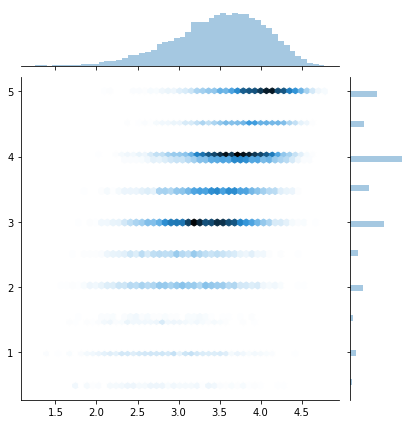

In [61]:
y=learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None);

# Normalized Weight Decay  

In [6]:
def get_norm_wds(w_norm, num_cycles, cycle_len, cycle_mult, bs, ds):
    """
    Returns a list of normalized weight decay factors.
    
    Arguments:
        w_norm: float, weight decay if only one batch pass is allowed
        num_cycles: int, number of cycles of model fitting (can include multiple epochs per cycle)
        cycle_len: int
        cycle_mult: int
        bs: batch size
        ds: total size of training data per epoch
    """
    epochs = []
    for i in range(num_cycles):
        # returns number of epochs in current cycle (before restart)
        epochs.append(cycle_mult ** (i) * cycle_len)
    
    cycle_wds = []
    for i in range(num_cycles):
        #returns weight decay per cycle
        cycle_wds.append(w_norm*math.sqrt(bs/(ds*epochs[i])))
    
    #wds = np.repeat(cycle_wds,epochs)
    return cycle_wds #wds.tolist()

In [65]:
# def get_norm_wds(w_norm, num_cycles, cycle_len, cycle_mult, bs, ds):
#     """
#     Returns a list of normalized weight decay factors.
    
#     Arguments:
#         w_norm: float, weight decay if only one batch pass is allowed
#         num_cycles: int, number of cycles of model fitting (can include multiple epochs per cycle)
#         cycle_len: int
#         cycle_mult: int
#         bs: batch size
#         ds: total size of training data per epoch
#     """
#     cycles = {}
    
#     if cycle_len==1 and cycle_mult==1:
#         cycles[num_cycles] = (w_norm*math.sqrt(bs/(ds*num_cycles)))
#     else:
#         for i in range(num_cycles):
#             # returns number of epochs in current cycle (before restart): weight decay per cycle
#             e = (cycle_mult ** (i) * cycle_len)
#             cycles[e] = (w_norm*math.sqrt(bs/(ds*e)))
#     return cycles

In [7]:
num_cycles=3
cycle_len=1
cycle_mult=2
bs=64
ds=20000
lr = 1e-2
opt_fn = optim.Adam

In [24]:
get_norm_wds(wd, num_cycles, cycle_len, cycle_mult, bs, ds)

[0.000565685424949238, 0.0004, 0.000282842712474619]

In [19]:
val_idxs = get_cv_idxs(len(ratings))
wd=1e-2
n_factors = 50
wds = get_norm_wds(wd, num_cycles, cycle_len, cycle_mult, bs, ds)

In [80]:
#normalize weights as per paper
def phases_sgdr(lr, opt_fn, num_cycles,cycle_len,cycle_mult, wds):
    phases = [TrainingPhase(epochs = cycle_len/ 20, opt_fn=opt_fn, lr=lr/100, wds=wds[0], wd_loss = False),
              TrainingPhase(epochs = cycle_len * 19/20, opt_fn=opt_fn, lr=lr, lr_decay=DecayType.COSINE,wds=wds[0], wd_loss = False)]
    for i in range(1,num_cycles):
        phases.append(TrainingPhase(epochs = cycle_len * (cycle_mult**i), opt_fn=opt_fn, lr=lr, lr_decay=DecayType.COSINE, wds=wds[i], wd_loss = False))
    return phases

## Weight Normalization as per paper 

In [21]:
wds = get_norm_wds(wd, num_cycles, cycle_len, cycle_mult, bs, ds)

phases = phases_sgdr(lr, opt_fn, num_cycles, cycle_len, cycle_mult, wds)

In [22]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [23]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.838813   0.828817  
    1      0.669769   0.922418                                  
    2      0.287654   0.880391                                  
    3      0.517452   1.095456                                  
    4      0.416222   0.972558                                  
    5      0.220323   0.925506                                  
    6      0.113722   0.928214                                  



[array([0.92821])]

In [108]:
wds = get_norm_wds(.5, num_cycles=3, cycle_len=1, cycle_mult=1, bs=64, ds=20000)

phases = phases_sgdr(lr, opt_fn, num_cycles, cycle_len, cycle_mult, wds)

In [109]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [110]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.785073   0.82656   
    1      0.662312   0.861541                                  
    2      0.282141   0.828163                                  
    3      0.52234    1.001732                                  
    4      0.367694   0.87579                                   
    5      0.184449   0.847705                                  
    6      0.089675   0.850258                                   



[array([0.85026])]

In [84]:
wds = get_norm_wds(.5, num_cycles, cycle_len, cycle_mult, bs, ds)

phases = phases_sgdr(lr, opt_fn, num_cycles, cycle_len, cycle_mult, wds)

In [85]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [86]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.840722   0.814594  
    1      0.655482   0.882071                                  
    2      0.278956   0.843825                                  
    3      0.488823   1.046477                                  
    4      0.394385   0.920414                                  
    5      0.187443   0.877783                                  
    6      0.091187   0.880569                                   



[array([0.88057])]

## No weight normalization 

In [37]:
# do not normalize weights as per paper
def phases_old_wd(lr, opt_fn, num_cycles,cycle_len,cycle_mult, wd):
    phases = [TrainingPhase(epochs = cycle_len/ 20, opt_fn=opt_fn, lr=lr/100, wds=wd),
              TrainingPhase(epochs = cycle_len * 19/20, opt_fn=opt_fn, lr=lr, lr_decay=DecayType.COSINE, wds=wd)]
    for i in range(1,num_cycles):
        phases.append(TrainingPhase(epochs = cycle_len * (cycle_mult**i), opt_fn=opt_fn, lr=lr, lr_decay=DecayType.COSINE, wds=wd))
    return phases

In [34]:
phases = phases_old_wd(lr, opt_fn, num_cycles, cycle_len, cycle_mult, 2e-4)

In [35]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [36]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.805931   0.805977  
    1      0.7508     0.77871                                   
    2      0.612604   0.763192                                  
    3      0.794279   0.801258                                  
    4      0.73214    0.770515                                  
    5      0.579349   0.757941                                  
    6      0.418965   0.75869                                   



[array([0.75869])]

## No weight normalization but wd_loss = False 

In [39]:
# do not normalize weights as per paper but use wd_loss = False
def phases_old_wd(lr, opt_fn, num_cycles,cycle_len,cycle_mult, wd):
    phases = [TrainingPhase(epochs = cycle_len/ 20, opt_fn=opt_fn, lr=lr/100, wds=wd, wd_loss=False),
              TrainingPhase(epochs = cycle_len * 19/20, opt_fn=opt_fn, lr=lr, lr_decay=DecayType.COSINE, wds=wd, wd_loss=False)]
    for i in range(1,num_cycles):
        phases.append(TrainingPhase(epochs = cycle_len * (cycle_mult**i), opt_fn=opt_fn, lr=lr, lr_decay=DecayType.COSINE, wds=wd, wd_loss=False))
    return phases

In [40]:
phases = phases_old_wd(lr, opt_fn, num_cycles, cycle_len, cycle_mult, 2e-4)

In [41]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [42]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.829294   0.841178  
    1      0.6884     0.942905                                  
    2      0.28941    0.902708                                  
    3      0.505963   1.116594                                  
    4      0.411975   1.007836                                  
    5      0.219323   0.958268                                  
    6      0.113115   0.962096                                  



[array([0.9621])]

In [77]:
phases = phases_old_wd(lr, opt_fn, num_cycles, cycle_len, cycle_mult, 8e-2)

In [78]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [79]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.805503   0.81131   
    1      0.682433   0.805213                                  
    2      0.345976   0.783939                                  
    3      0.614124   0.903773                                  
    4      0.443737   0.813775                                  
    5      0.264871   0.795335                                  
    6      0.138686   0.797155                                  



[array([0.79715])]

## Weight normalization but wd_loss = True 

In [43]:
#normalize weights as per paper but leave wd_loss = True
def phases_sgdr(lr, opt_fn, num_cycles,cycle_len,cycle_mult, wds):
    phases = [TrainingPhase(epochs = cycle_len/ 20, opt_fn=opt_fn, lr=lr/100, wds=wds[0], wd_loss = True),
              TrainingPhase(epochs = cycle_len * 19/20, opt_fn=opt_fn, lr=lr, lr_decay=DecayType.COSINE,wds=wds[0], wd_loss = True)]
    for i in range(1,num_cycles):
        phases.append(TrainingPhase(epochs = cycle_len * (cycle_mult**i), opt_fn=opt_fn, lr=lr, lr_decay=DecayType.COSINE, wds=wds[i], wd_loss = True))
    return phases

In [44]:
wds = get_norm_wds(1e-2, num_cycles, cycle_len, cycle_mult, bs, ds)

phases = phases_sgdr(lr, opt_fn, num_cycles, cycle_len, cycle_mult, wds)

In [45]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [46]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.855573   0.861702  
    1      0.83234    0.813897                                  
    2      0.783898   0.806856                                  
    3      0.803323   0.803922                                  
    4      0.784651   0.783516                                  
    5      0.698854   0.77188                                   
    6      0.611618   0.770471                                  



[array([0.77047])]

In [47]:
wds = get_norm_wds(1e-3, num_cycles, cycle_len, cycle_mult, bs, ds)

phases = phases_sgdr(lr, opt_fn, num_cycles, cycle_len, cycle_mult, wds)

In [48]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [49]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.806813   0.796494  
    1      0.687516   0.841668                                  
    2      0.25407    0.813521                                  
    3      0.588308   1.014065                                  
    4      0.338147   0.886498                                  
    5      0.170752   0.848903                                  
    6      0.082675   0.848302                                   



[array([0.8483])]

In [65]:
wds = get_norm_wds(6e-3, num_cycles, cycle_len, cycle_mult, bs, ds)

phases = phases_sgdr(lr, opt_fn, num_cycles, cycle_len, cycle_mult, wds)

In [66]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [67]:
learn.fit_opt_sched(phases)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.827845   0.827293  
    1      0.783376   0.788963                                  
    2      0.684618   0.772988                                  
    3      0.78681    0.798178                                  
    4      0.682574   0.77073                                   
    5      0.545468   0.760203                                  
    6      0.349133   0.760914                                  



[array([0.76091])]